<a href="https://colab.research.google.com/github/nikunjlad/3D-Object-Classification-Using-Capsule-Networks/blob/parag/ConvNets_with_COIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Convolutional Neural Networks 

In [0]:
!pip install pydrive

In [0]:
from __future__ import print_function
from keras import backend as K
from keras.layers import Layer
from keras import activations,optimizers
from keras import utils
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator

#--------------linear algebra, data processing----------#
import numpy as np 
import pandas as pd
import glob,string
import codecs
from tqdm import tqdm

#--------------Google authentication--------------------#
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
import tensorflow as tf
from oauth2client.client import GoogleCredentials

### Google authentication
* fetch the dataset from google drive 
* unzip the extracted file 

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
zip_file = drive.CreateFile({'id': '1SVo_UonxSflAzAqWQhqUrJFPLvyTc3vA'})
zip_file.GetContentFile('coil-100.zip')

In [0]:
!unzip 'coil-100.zip'

## Data processing and visualization

In [0]:
path ='coil-100/'
#list files
files=glob.glob(path)

In [0]:
def contructDataframe(file_list):
    data=[]
    for file in tqdm(file_list):
        data.append((file,file.split("/")[-1].split("__")[0]))
    return pd.DataFrame(data,columns=['path','label'])

In [0]:
df=contructDataframe(files)

100%|██████████| 7200/7200 [00:00<00:00, 208070.86it/s]


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.path, df.label, test_size=0.20,random_state=0,stratify= df.label)

In [0]:
from keras.preprocessing.image import load_img,img_to_array
import cv2
X_train=[img_to_array(cv2.imread(file).astype("float")/255.0) for file in tqdm(X_train.values)]

100%|██████████| 5760/5760 [00:13<00:00, 425.40it/s]


In [0]:
X_test=[img_to_array(cv2.imread(file).astype("float")/255.0) for file in tqdm(X_test.values)]

100%|██████████| 1440/1440 [00:03<00:00, 440.15it/s]


In [0]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_train_categorical=encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_categorical=encoder.transform(y_test.values.reshape(-1, 1))

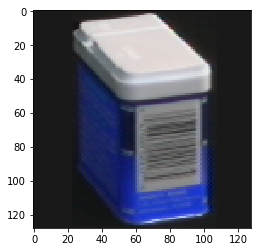

In [0]:
import matplotlib.pyplot as plt
img = X_train[32]
plt.imshow(img)
plt.show()

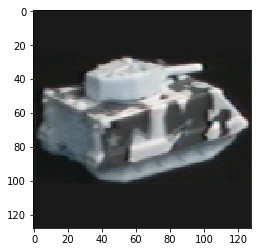

In [0]:
import matplotlib.pyplot as plt
img = X_test[44]
plt.imshow(img)
plt.show()

## Validation Split

In [0]:
X_train=np.array(X_train)
X_test=np.array(X_test)

In [0]:
X_train, X_validation, y_train_categorical, y_validation_categorical = train_test_split(X_train, y_train_categorical, test_size=0.15,random_state=0,stratify= y_train_categorical)

## Model Designing

In [0]:
def create_model(activation,num_classes):
  
    model = Sequential()
    model.add(Conv2D(16, (3, 3), input_shape=(128, 128, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation=activation))
    return model

In [0]:
activation='softmax'
num_classes =100
model = create_model(activation,num_classes=num_classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 62, 62, 32)        2080      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 31, 31, 32)        128       
_________________________________________________________________
flatten_5 (Flatten)          (None, 30752)             0         
__________

### Callbacks
The following code will monitor the performace of the model. If there is increase in accuracy of model and decrease in loss, a checkpoint file will be created. When improvement will stop the callback function will reduce the learning rate and after while it will stop the training and avoid overfitting

In [0]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
patience =4

#log_file_path = base_path + dataset_name + '_emotion_training.log'
#csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=int(patience/4), verbose=1)
trained_models_path = 'trained_model_2'
model_names = trained_models_path + '.{epoch:02d}.{val_acc:02f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, early_stop, reduce_lr]

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

history = model.fit(X_train,y_train_categorical,
          validation_data=(X_validation,y_validation_categorical),
          shuffle=True,
          callbacks=callbacks,
          epochs = 20,
          batch_size=16
         )

Train on 4896 samples, validate on 864 samples
Epoch 1/20
4896/4896 [==============================] - 199s 41ms/step - loss: 1.6509 - acc: 0.6287 - val_loss: 0.4395 - val_acc: 0.8808

Epoch 00001: val_loss improved from inf to 0.43950, saving model to trained_model_2.01.0.880787.hdf5
Epoch 2/20
4896/4896 [==============================] - 130s 26ms/step - loss: 0.2124 - acc: 0.9406 - val_loss: 0.5859 - val_acc: 0.8438

Epoch 00002: val_loss did not improve from 0.43950

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3/20
4896/4896 [==============================] - 93s 19ms/step - loss: 0.0325 - acc: 0.9922 - val_loss: 0.0360 - val_acc: 0.9896

Epoch 00003: val_loss improved from 0.43950 to 0.03596, saving model to trained_model_2.03.0.989583.hdf5
Epoch 4/20
4896/4896 [==============================] - 93s 19ms/step - loss: 0.0122 - acc: 0.9971 - val_loss: 0.0245 - val_acc: 0.9942

Epoch 00004: val_loss improved from 0.03596 to 0.02448, saving m

In [0]:
def plotter(trained_record):
    # Loss Curves
    plt.figure(figsize=[8,6])
    plt.plot(trained_record.history['loss'],'r',linewidth=3.0)
    plt.plot(trained_record.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)
    plt.savefig('loss_COIL.png')
    # Accuracy Curves
    plt.figure(figsize=[8,6])
    plt.plot(trained_record.history['acc'],'r',linewidth=3.0)
    plt.plot(trained_record.history['val_acc'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)

    plt.savefig('accuracy_COIL100.png')

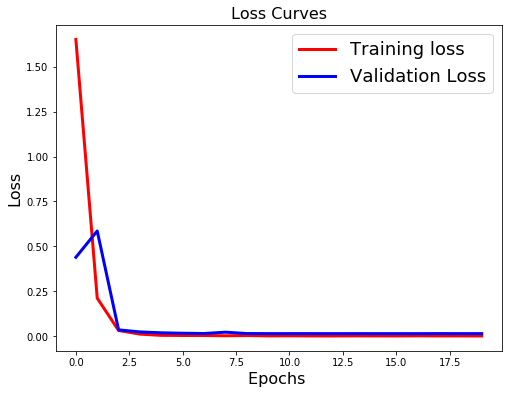

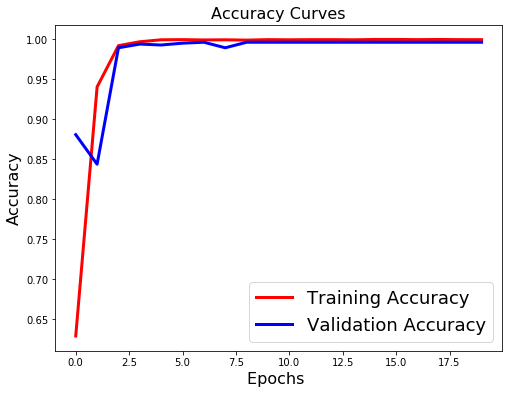

In [0]:
plotter(history)